# 2. Численное дифференцирование

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from scipy import differentiate

In [161]:
def forward_first_derivative(f: Callable, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h = grid[1] - grid[0]
    return grid[:-1], (f(grid[1:]) - f(grid[:-1])) / h

def central_first_derivative(f: Callable, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h = grid[1] - grid[0]
    return grid[1:-1], (f(grid[2:]) - f(grid[:-2])) / (2 * h)

def second_derivative_2(f: Callable, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h = grid[1] - grid[0]
    return grid[1:-1], (f(grid[2:]) - 2 * f(grid[1:-1]) + f(grid[:-2])) / h ** 2

def second_derivative_4(f: Callable, grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    h = grid[1] - grid[0]
    return grid[2:-2], ( - f(grid[4:]) + 16 * f(grid[3:-1]) - 30 * f(grid[2:-2]) + 16 * f(grid[1:-3]) - f(grid[:-4])) / (12 * h ** 2)

In [162]:
def derivative(
    grid: np.ndarray, 
    f_grid: np.ndarray, 
    order: int, 
    points: Tuple[int, int] = None, 
    boundaries: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    from math import factorial

    if points is None:
        p_left, p_right = order, order
    else:
        p_left, p_right = points

    n = len(grid)
    der_f = []

    if boundaries:
        indices = range(n)
    else:
        indices = range(p_left, n - p_right)

    for i in indices:
        size = p_left + p_right + 1

        start = i - p_left
        end = i + p_right + 1

        if start < 0:
            end += -start
            start = 0
        if end > n:
            start -= (end - n)
            end = n

        x_stencil = grid[start:end]
        x_rel = x_stencil - grid[i]

        H = x_rel[np.newaxis, :] ** np.arange(len(x_rel))[:, np.newaxis]
        b = np.zeros(len(x_rel))
        b[order] = factorial(order)

        coeffs = np.linalg.solve(H, b)
        stencil_f = f_grid[start:end]
        der_f.append(np.dot(coeffs, stencil_f))

    der_grid = grid[list(indices)]
    return der_grid, np.array(der_f)


In [163]:
a, b = -3, 3
h = 0.5

def f(x: np.ndarray) -> np.ndarray:
    return np.atan(np.sin(x))

def d_f(x: np.ndarray) -> np.ndarray:
    return np.cos(x) / (1 + np.sin(x) ** 2)

grid = np.arange(a, b + h, h, dtype=np.float128)

grid1, derivative1 = forward_first_derivative(f, grid)
grid2, derivative2 = central_first_derivative(f, grid)
grid3, derivative3 = second_derivative_2(f, grid)
grid4, derivative4 = second_derivative_4(f, grid)

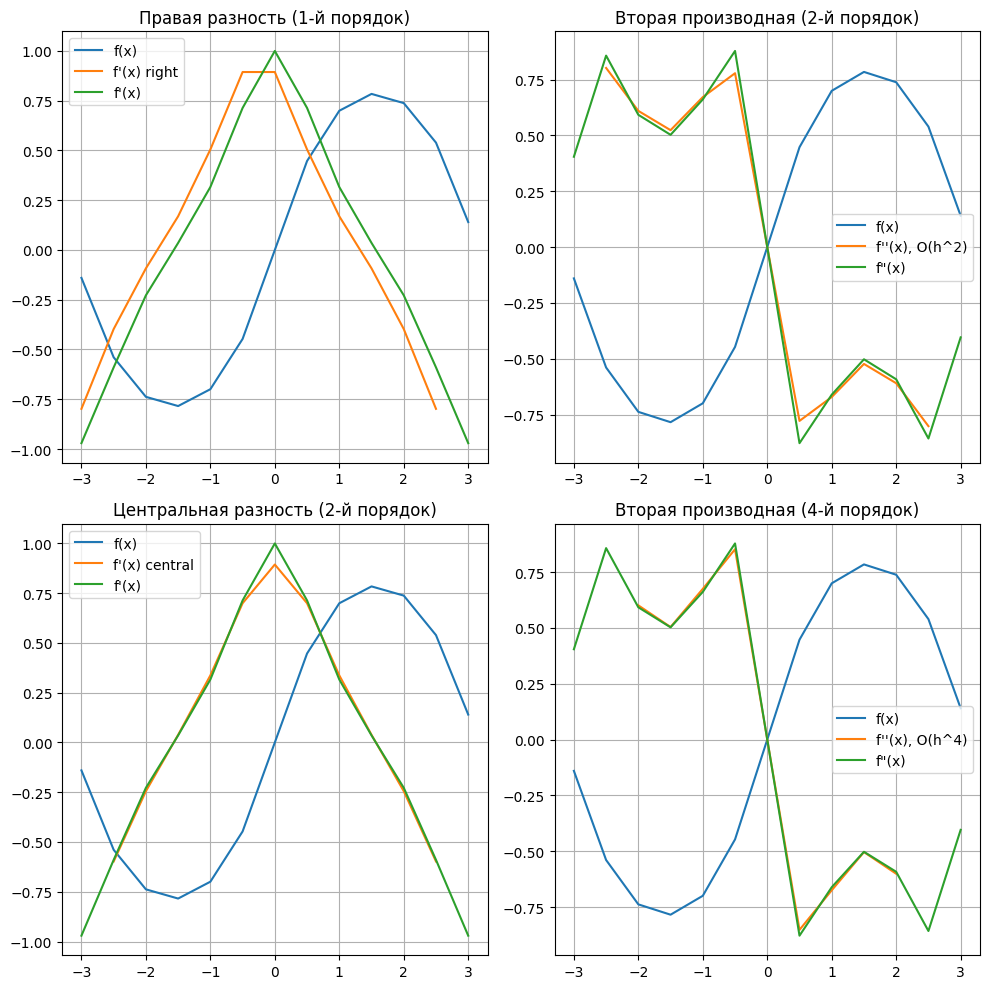

In [164]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(2, 2, figsize=(10, 10))

axis[0, 0].plot(grid, f(grid), label="f(x)")
axis[0, 0].plot(grid1, derivative1, label="f'(x) right")
axis[0, 0].plot(grid, d_f(grid), label="f'(x)")
axis[0, 0].set_title("Правая разность (1-й порядок)")
axis[0, 0].legend()
axis[0, 0].grid(True)

axis[1, 0].plot(grid, f(grid), label="f(x)")
axis[1, 0].plot(grid2, derivative2, label="f'(x) central")
axis[1, 0].plot(grid, d_f(grid), label="f'(x)")
axis[1, 0].set_title("Центральная разность (2-й порядок)")
axis[1, 0].legend()
axis[1, 0].grid(True)

axis[0, 1].plot(grid, f(grid), label="f(x)")
axis[0, 1].plot(grid3, derivative3, label="f''(x), O(h^2)")
axis[0, 1].plot(grid, differentiate.derivative(d_f, grid).df, label="f\"(x)")
axis[0, 1].set_title("Вторая производная (2-й порядок)")
axis[0, 1].legend()
axis[0, 1].grid(True)

axis[1, 1].plot(grid, f(grid), label="f(x)")
axis[1, 1].plot(grid4, derivative4, label="f''(x), O(h^4)")
axis[1, 1].plot(grid, differentiate.derivative(d_f, grid).df, label="f\"(x)")
axis[1, 1].set_title("Вторая производная (4-й порядок)")
axis[1, 1].legend()
axis[1, 1].grid(True)

plt.tight_layout()
plt.show()


100%|██████████| 50/50 [00:00<00:00, 64.73it/s] 


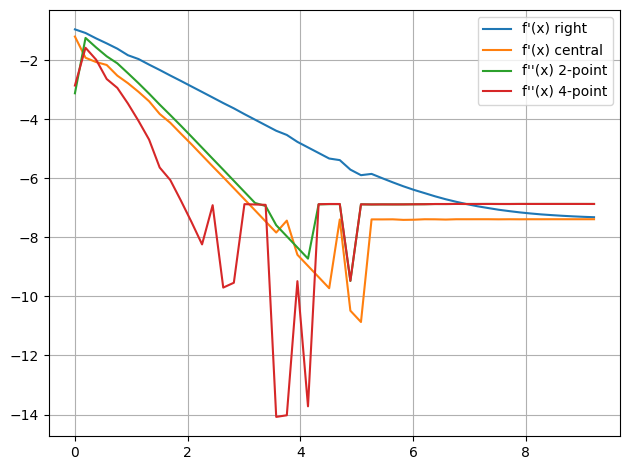

In [165]:
from tqdm import tqdm

forward_first_derivative_history = []
central_first_derivative_history = []
second_derivative_2_history = []
second_derivative_4_history = []

for c in tqdm(np.logspace(0, 4, num=50)):
    h = 1 / c
    grid = np.arange(a, b + h, h, dtype=float)

    grid1, derivative1 = forward_first_derivative(f, grid)
    grid2, derivative2 = central_first_derivative(f, grid)
    grid3, derivative3 = second_derivative_2(f, grid)
    grid4, derivative4 = second_derivative_4(f, grid)

    first_derivative = differentiate.derivative(f, grid, order=1).df
    second_derivative = differentiate.derivative(d_f, grid, order=2).df

    forward_first_derivative_history.append(max(abs(derivative1 - first_derivative[1:])))
    central_first_derivative_history.append(max(abs(derivative2 - first_derivative[1:-1])))
    second_derivative_2_history.append(max(abs(derivative3 - second_derivative[1:-1])))
    second_derivative_4_history.append(max(abs(derivative4 - second_derivative[2:-2])))

plt.plot(np.log(np.logspace(0, 4, num=50)), np.log(forward_first_derivative_history), label="f'(x) right")
plt.plot(np.log(np.logspace(0, 4, num=50)), np.log(central_first_derivative_history), label="f'(x) central")
plt.plot(np.log(np.logspace(0, 4, num=50)), np.log(second_derivative_2_history), label="f''(x) 2-point")
plt.plot(np.log(np.logspace(0, 4, num=50)), np.log(second_derivative_4_history), label="f''(x) 4-point")

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

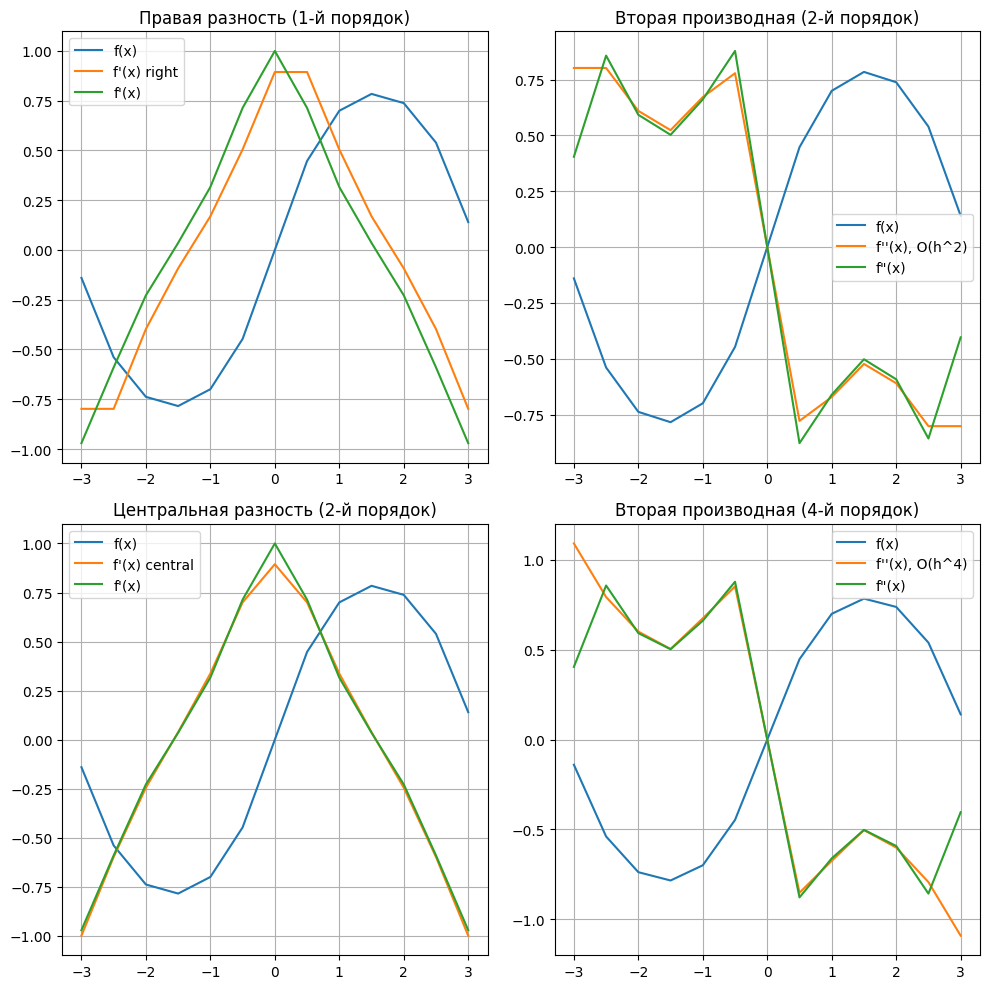

In [166]:
a, b = -3, 3
h = 0.5

def f(x: np.ndarray) -> np.ndarray:
    return np.atan(np.sin(x))

grid = np.arange(a, b + h, h, dtype=float)

grid1, derivative1 = derivative(grid, f(grid), 1, points=(1, 0))
grid2, derivative2 = derivative(grid, f(grid), 1, points=(1, 1))
grid3, derivative3 = derivative(grid, f(grid), 2, points=(1, 1))
grid4, derivative4 = derivative(grid, f(grid), 2, points=(2, 2))

fig, axis = plt.subplots(2, 2, figsize=(10, 10))

axis[0, 0].plot(grid, f(grid), label="f(x)")
axis[0, 0].plot(grid1, derivative1, label="f'(x) right")
axis[0, 0].plot(grid, d_f(grid), label="f'(x)")
axis[0, 0].set_title("Правая разность (1-й порядок)")
axis[0, 0].legend()
axis[0, 0].grid(True)

axis[1, 0].plot(grid, f(grid), label="f(x)")
axis[1, 0].plot(grid2, derivative2, label="f'(x) central")
axis[1, 0].plot(grid, d_f(grid), label="f'(x)")
axis[1, 0].set_title("Центральная разность (2-й порядок)")
axis[1, 0].legend()
axis[1, 0].grid(True)

axis[0, 1].plot(grid, f(grid), label="f(x)")
axis[0, 1].plot(grid3, derivative3, label="f''(x), O(h^2)")
axis[0, 1].plot(grid, differentiate.derivative(d_f, grid).df, label="f\"(x)")
axis[0, 1].set_title("Вторая производная (2-й порядок)")
axis[0, 1].legend()
axis[0, 1].grid(True)

axis[1, 1].plot(grid, f(grid), label="f(x)")
axis[1, 1].plot(grid4, derivative4, label="f''(x), O(h^4)")
axis[1, 1].plot(grid, differentiate.derivative(d_f, grid).df, label="f\"(x)")
axis[1, 1].set_title("Вторая производная (4-й порядок)")
axis[1, 1].legend()
axis[1, 1].grid(True)

plt.tight_layout()
plt.show()

100%|██████████| 50/50 [00:07<00:00,  6.88it/s] 


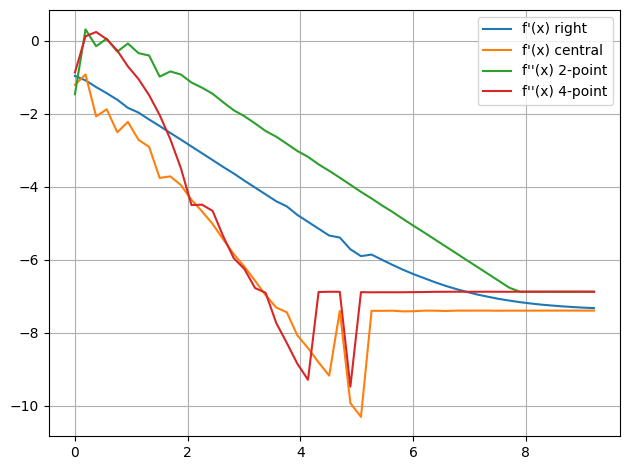

In [167]:
from tqdm import tqdm

forward_first_derivative_history = []
central_first_derivative_history = []
second_derivative_2_history = []
second_derivative_4_history = []

for c in tqdm(np.logspace(0, 4, num=50)):
    h = 1 / c
    grid = np.arange(a, b + h, h, dtype=float)

    grid1, derivative1 = derivative(grid, f(grid), 1, points=(1, 0))
    grid2, derivative2 = derivative(grid, f(grid), 1, points=(1, 1))
    grid3, derivative3 = derivative(grid, f(grid), 2, points=(1, 1))
    grid4, derivative4 = derivative(grid, f(grid), 2, points=(2, 2))

    first_derivative = differentiate.derivative(f, grid, order=1).df
    second_derivative = differentiate.derivative(d_f, grid, order=2).df

    forward_first_derivative_history.append(max(abs(derivative1 - first_derivative)))
    central_first_derivative_history.append(max(abs(derivative2 - first_derivative)))
    second_derivative_2_history.append(max(abs(derivative3 - second_derivative)))
    second_derivative_4_history.append(max(abs(derivative4 - second_derivative)))

plt.plot(np.log(np.logspace(0, 4, num=50)), np.log(forward_first_derivative_history), label="f'(x) right")
plt.plot(np.log(np.logspace(0, 4, num=50)), np.log(central_first_derivative_history), label="f'(x) central")
plt.plot(np.log(np.logspace(0, 4, num=50)), np.log(second_derivative_2_history), label="f''(x) 2-point")
plt.plot(np.log(np.logspace(0, 4, num=50)), np.log(second_derivative_4_history), label="f''(x) 4-point")

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()